In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [1]:
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.set_num_threads(7)
from commons import *
from SMS import *

In [2]:
import csv

CATEGORIES = ['genre', 'instrument', 'mood/theme']
TAG_HYPHEN = '---'
METADATA_DESCRIPTION = 'TSV file with such columns: TRACK_ID, ARTIST_ID, ALBUM_ID, PATH, DURATION, TAGS'


def get_id(value):
    return int(value.split('_')[1])


def get_length(values):
    return len(str(max(values)))


def read_file(tsv_file):
    tracks = {}
    tags = {category: {} for category in CATEGORIES}

    # For statistics
    artist_ids = set()
    albums_ids = set()

    with open(tsv_file) as fp:
        reader = csv.reader(fp, delimiter='\t')
        next(reader, None)  # skip header
        for row in reader:
            track_id = get_id(row[0])
            tracks[track_id] = {
                'artist_id': get_id(row[1]),
                'album_id': get_id(row[2]),
                'path': row[3],
                'duration': float(row[4]),
                'tags': row[5:],  # raw tags, not sure if will be used
            }
            tracks[track_id].update({category: set() for category in CATEGORIES})

            artist_ids.add(get_id(row[1]))
            albums_ids.add(get_id(row[2]))

            for tag_str in row[5:]:
                category, tag = tag_str.split(TAG_HYPHEN)

                if tag not in tags[category]:
                    tags[category][tag] = set()

                tags[category][tag].add(track_id)

                tracks[track_id][category].add(tag)

    print("Reading: {} tracks, {} albums, {} artists".format(len(tracks), len(albums_ids), len(artist_ids)))

    extra = {
        'track_id_length': get_length(tracks.keys()),
        'artist_id_length': get_length(artist_ids),
        'album_id_length': get_length(albums_ids)
    }
    return tracks, tags, extra


def write_file(tracks, tsv_file, extra):
    rows = []
    for track_id, track in tracks.items():
        row = [
            'track_' + str(track_id).zfill(extra['track_id_length']),
            'artist_' + str(track['artist_id']).zfill(extra['artist_id_length']),
            'album_' + str(track['album_id']).zfill(extra['album_id_length']),
            track['path'],
            track['duration']
        ]

        tags = []
        for category in CATEGORIES:
            tags += [category + '---' + tag for tag in track[category]]

        row += sorted(tags)
        rows.append(row)

    with open(tsv_file, 'w') as fp:
        writer = csv.writer(fp, delimiter='\t')
        writer.writerow(['TRACK_ID', 'ARTIST_ID', 'ALBUM_ID', 'PATH', 'DURATION', 'TAGS'])
        for row in rows:
            writer.writerow(row)

In [3]:
train_info = read_file('../data/splits/split-0/autotagging_moodtheme-train.tsv')
validation_info = read_file('../data/splits/split-0/autotagging_moodtheme-validation.tsv')
test_info = read_file('../data/splits/split-0/autotagging_moodtheme-test.tsv')

Reading: 9949 tracks, 2471 albums, 874 artists
Reading: 3802 tracks, 927 albums, 307 artists
Reading: 4231 tracks, 1025 albums, 327 artists


In [4]:
def parse(a_info):
    ans = []
    for k,v in a_info[1]['mood/theme'].items():
        ans.append(pd.DataFrame({
            k: 1,
            'file': list(v)
        }))

    df = ans[0]
    for x in ans[1:]:
        df = pd.merge(df, x, on='file', how='outer')
    df = df.set_index('file').fillna(0)
    df.loc[:, :] = df.loc[:, :].astype('int64')
    return df

In [5]:
train_df = parse(train_info)
valid_df = parse(validation_info)
test_df = parse(test_info)

In [6]:
train_df.shape
valid_df.shape
test_df.shape

(4231, 56)

In [7]:
train_df.columns

Index(['background', 'film', 'melancholic', 'melodic', 'children', 'relaxing',
       'documentary', 'emotional', 'space', 'love', 'drama', 'adventure',
       'energetic', 'heavy', 'dark', 'calm', 'action', 'dramatic', 'epic',
       'powerful', 'upbeat', 'slow', 'inspiring', 'soft', 'meditative', 'fun',
       'happy', 'positive', 'romantic', 'sad', 'hopeful', 'motivational',
       'deep', 'uplifting', 'ballad', 'soundscape', 'dream', 'movie', 'fast',
       'nature', 'cool', 'corporate', 'travel', 'funny', 'sport', 'commercial',
       'advertising', 'holiday', 'christmas', 'sexy', 'game', 'groovy',
       'retro', 'summer', 'party', 'trailer'],
      dtype='object')

In [8]:
train_df = train_df.loc[:, sorted(train_df.columns.tolist())]
valid_df = valid_df.loc[:, sorted(train_df.columns.tolist())]
test_df = test_df.loc[:, sorted(train_df.columns.tolist())]

In [9]:
train_df.columns

Index(['action', 'adventure', 'advertising', 'background', 'ballad', 'calm',
       'children', 'christmas', 'commercial', 'cool', 'corporate', 'dark',
       'deep', 'documentary', 'drama', 'dramatic', 'dream', 'emotional',
       'energetic', 'epic', 'fast', 'film', 'fun', 'funny', 'game', 'groovy',
       'happy', 'heavy', 'holiday', 'hopeful', 'inspiring', 'love',
       'meditative', 'melancholic', 'melodic', 'motivational', 'movie',
       'nature', 'party', 'positive', 'powerful', 'relaxing', 'retro',
       'romantic', 'sad', 'sexy', 'slow', 'soft', 'soundscape', 'space',
       'sport', 'summer', 'trailer', 'travel', 'upbeat', 'uplifting'],
      dtype='object')

In [10]:
def np_load_gz(x):
    with gzip.open(x, 'rb') as f:
        return np.load(f)

In [11]:
import random
def random_30s(x):
    x_len = x.shape[1]
    offset = random.randint(0, (x_len - 1407))
    return x[:, offset:(offset + 1407)]
from transformer import *

In [12]:
import math
import random
import numpy as np
from PIL import Image


def resize(img, size, interpolation=Image.BILINEAR):
    r"""Resize the input PIL Image to the given size.
    Args:
        img (PIL Image): Image to be resized.
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), the output size will be matched to this. If size is an int,
            the smaller edge of the image will be matched to this number maintaing
            the aspect ratio. i.e, if height > width, then image will be rescaled to
            :math:`\left(\text{size} \times \frac{\text{height}}{\text{width}}, \text{size}\right)`
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    Returns:
        PIL Image: Resized image.
    """
    if isinstance(size, int):
        w, h = img.size
        if (w <= h and w == size) or (h <= w and h == size):
            return img
        if w < h:
            ow = size
            oh = int(size * h / w)
            return img.resize((ow, oh), interpolation)
        else:
            oh = size
            ow = int(size * w / h)
            return img.resize((ow, oh), interpolation)
    else:
        return img.resize(size[::-1], interpolation)


def crop(img, i, j, h, w):
    """Crop the given PIL Image.
    Args:
        img (PIL Image): Image to be cropped.
        i (int): i in (i,j) i.e coordinates of the upper left corner.
        j (int): j in (i,j) i.e coordinates of the upper left corner.
        h (int): Height of the cropped image.
        w (int): Width of the cropped image.
    Returns:
        PIL Image: Cropped image.
    """
    return img.crop((j, i, j + w, i + h))


def resized_crop(img, i, j, h, w, size, interpolation=Image.BILINEAR):
    """Crop the given PIL Image and resize it to desired size.
    Notably used in :class:`~torchvision.transforms.RandomResizedCrop`.
    Args:
        img (PIL Image): Image to be cropped.
        i (int): i in (i,j) i.e coordinates of the upper left corner
        j (int): j in (i,j) i.e coordinates of the upper left corner
        h (int): Height of the cropped image.
        w (int): Width of the cropped image.
        size (sequence or int): Desired output size. Same semantics as ``resize``.
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``.
    Returns:
        PIL Image: Cropped image.
    """
    img = crop(img, i, j, h, w)
    img = resize(img, size, interpolation)
    return img


class RandomResizedCrop(object):
    """Crop the given PIL Image to random size and aspect ratio.
    A crop of random size (default: of 0.08 to 1.0) of the original size and a random
    aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: expected output size of each edge
        scale: range of size of the origin size cropped
        ratio: range of aspect ratio of the origin aspect ratio cropped
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size=None, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=Image.BILINEAR):
        if isinstance(size, tuple) or size is None:
            self.size = size
        else:
            self.size = (size, size)
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("range should be of kind (min, max)")

        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img, scale, ratio):
        """Get parameters for ``crop`` for a random sized crop.
        Args:
            img (PIL Image): Image to be cropped.
            scale (tuple): range of size of the origin size cropped
            ratio (tuple): range of aspect ratio of the origin aspect ratio cropped
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """
        area = img.size[0] * img.size[1]

        for attempt in range(10):
            target_area = random.uniform(*scale) * area
            log_ratio = (math.log(ratio[0]), math.log(ratio[1]))
            aspect_ratio = math.exp(random.uniform(*log_ratio))

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.size[0] and h <= img.size[1]:
                i = random.randint(0, img.size[1] - h)
                j = random.randint(0, img.size[0] - w)
                return i, j, h, w

        # Fallback to central crop
        in_ratio = img.size[0] / img.size[1]
        if (in_ratio < min(ratio)):
            w = img.size[0]
            h = w / min(ratio)
        elif (in_ratio > max(ratio)):
            h = img.size[1]
            w = h * max(ratio)
        else:  # whole image
            w = img.size[0]
            h = img.size[1]
        i = (img.size[1] - h) // 2
        j = (img.size[0] - w) // 2
        return i, j, h, w

    def __call__(self, np_image):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.
        Returns:
            PIL Image: Randomly cropped and resized image.
        """

        if self.size is None:
            size = np_image.shape
        else:
            size = self.size

        image = Image.fromarray(np_image)
        i, j, h, w = self.get_params(image, self.scale, self.ratio)
        image = resized_crop(image, i, j, h, w, size, self.interpolation)
        np_image = np.array(image)
        return np_image

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        format_string = self.__class__.__name__ + '(size={0}'.format(self.size)
        format_string += ', scale={0}'.format(tuple(round(s, 4) for s in self.scale))
        format_string += ', ratio={0}'.format(tuple(round(r, 4) for r in self.ratio))
        format_string += ', interpolation={0})'.format(interpolate_str)
        return format_string

In [13]:
import cv2
import torch
import random
import librosa
import numpy as np

#from random_resized_crop import RandomResizedCrop

cv2.setNumThreads(0)


def image_crop(image, bbox):
    return image[bbox[1]:bbox[3], bbox[0]:bbox[2]]


def gauss_noise(image, sigma_sq):
    h, w = image.shape
    gauss = np.random.normal(0, sigma_sq, (h, w))
    gauss = gauss.reshape(h, w)
    image = image + gauss
    return image


# Source: https://www.kaggle.com/davids1992/specaugment-quick-implementation
def spec_augment(spec: np.ndarray,
                 num_mask=2,
                 freq_masking=0.15,
                 time_masking=0.20,
                 value=0):
    spec = spec.copy()
    num_mask = random.randint(1, num_mask)
    for i in range(num_mask):
        all_freqs_num, all_frames_num  = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[f0:f0 + num_freqs_to_mask, :] = value

        time_percentage = random.uniform(0.0, time_masking)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[:, t0:t0 + num_frames_to_mask] = value
    return spec


class SpecAugment:
    def __init__(self,
                 num_mask=2,
                 freq_masking=0.15,
                 time_masking=0.20):
        self.num_mask = num_mask
        self.freq_masking = freq_masking
        self.time_masking = time_masking

    def __call__(self, image):
        return spec_augment(image,
                            self.num_mask,
                            self.freq_masking,
                            self.time_masking,
                            image.min())


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, trg=None):
        if trg is None:
            for t in self.transforms:
                image = t(image)
            return image
        else:
            for t in self.transforms:
                image, trg = t(image, trg)
            return image, trg


class UseWithProb:
    def __init__(self, transform, prob=.5):
        self.transform = transform
        self.prob = prob

    def __call__(self, image, trg=None):
        if trg is None:
            if random.random() < self.prob:
                image = self.transform(image)
            return image
        else:
            if random.random() < self.prob:
                image, trg = self.transform(image, trg)
            return image, trg


class OneOf:
    def __init__(self, transforms, p=None):
        self.transforms = transforms
        self.p = p

    def __call__(self, image, trg=None):
        transform = np.random.choice(self.transforms, p=self.p)
        if trg is None:
            image = transform(image)
            return image
        else:
            image, trg = transform(image, trg)
            return image, trg


class Flip:
    def __init__(self, flip_code):
        assert flip_code == 0 or flip_code == 1
        self.flip_code = flip_code

    def __call__(self, image):
        image = cv2.flip(image, self.flip_code)
        return image


class HorizontalFlip(Flip):
    def __init__(self):
        super().__init__(1)


class VerticalFlip(Flip):
    def __init__(self):
        super().__init__(0)


class GaussNoise:
    def __init__(self, sigma_sq):
        self.sigma_sq = sigma_sq

    def __call__(self, image):
        if self.sigma_sq > 0.0:
            image = gauss_noise(image,
                                np.random.uniform(0, self.sigma_sq))
        return image


class RandomGaussianBlur:
    '''Apply Gaussian blur with random kernel size
    Args:
        max_ksize (int): maximal size of a kernel to apply, should be odd
        sigma_x (int): Standard deviation
    '''
    def __init__(self, max_ksize=5, sigma_x=20):
        assert max_ksize % 2 == 1, "max_ksize should be odd"
        self.max_ksize = max_ksize // 2 + 1
        self.sigma_x = sigma_x

    def __call__(self, image):
        kernel_size = tuple(2 * np.random.randint(0, self.max_ksize, 2) + 1)
        blured_image = cv2.GaussianBlur(image, kernel_size, self.sigma_x)
        return blured_image


class ImageToTensor:
    def __call__(self, image):
        #delta = librosa.feature.delta(image)
        #accelerate = librosa.feature.delta(image, order=2)
        #image = np.stack([image, delta, accelerate], axis=0)
        image = image[None, :, :]
        image = image.astype(np.float32) / 100
        image = torch.from_numpy(image)
        return image


class RandomCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, signal):
        start = random.randint(0, signal.shape[1] - self.size)
        return signal[:, start: start + self.size]


class CenterCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, signal):

        if signal.shape[1] > self.size:
            start = (signal.shape[1] - self.size) // 2
            return signal[:, start: start + self.size]
        else:
            return signal


class PadToSize:
    def __init__(self, size, mode='constant'):
        assert mode in ['constant', 'wrap']
        self.size = size
        self.mode = mode

    def __call__(self, signal):
        if signal.shape[1] < self.size:
            padding = self.size - signal.shape[1]
            offset = padding // 2
            pad_width = ((0, 0), (offset, padding - offset))
            if self.mode == 'constant':
                signal = np.pad(signal, pad_width,
                                'constant', constant_values=signal.min())
            else:
                signal = np.pad(signal, pad_width, 'wrap')
        return signal


def get_transforms(train, size,
                   wrap_pad_prob=0.5,
                   resize_scale=(0.8, 1.0),
                   resize_ratio=(1.7, 2.3),
                   resize_prob=0.33,
                   spec_num_mask=2,
                   spec_freq_masking=0.15,
                   spec_time_masking=0.20,
                   spec_prob=0.5):
    if train:
        transforms = Compose([
            OneOf([
                PadToSize(size, mode='wrap'),
                PadToSize(size, mode='constant'),
            ], p=[wrap_pad_prob, 1 - wrap_pad_prob]),
            RandomCrop(size),
            UseWithProb(
                RandomResizedCrop(scale=resize_scale, ratio=resize_ratio),
                prob=resize_prob
            ),
            UseWithProb(SpecAugment(num_mask=spec_num_mask,
                                    freq_masking=spec_freq_masking,
                                    time_masking=spec_time_masking), spec_prob),
            ImageToTensor()
        ])
    else:
        transforms = Compose([
            PadToSize(size),
            CenterCrop(size),
            ImageToTensor()
        ])
    return transforms

In [14]:
train_transform = get_transforms(
    train=True,
    size=6590,
    wrap_pad_prob=0.5,
    resize_scale=(0.8, 1.0),
    resize_ratio=(1.7, 2.3),
    resize_prob=0.33,
    spec_num_mask=2,
    spec_freq_masking=0.15,
    spec_time_masking=0.20,
    spec_prob=0.5
)
val_transform = get_transforms(False, 6590)

In [15]:
class AudioDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        this_file = self.df.index[idx]
        sample = np.load('../melspecdataset/{}.npy'.format(this_file))
        
        image = sample
                
        if self.transform is not None:
            image = self.transform(image)
        
        return image, torch.Tensor(self.df.values[idx])

In [16]:
train_dataset = AudioDataset(train_df, train_transform)
valid_dataset = AudioDataset(valid_df, val_transform)
test_dataset = AudioDataset(test_df, val_transform)

In [17]:
train_dataset[100][0].shape, train_dataset[100][1].shape

(torch.Size([1, 96, 6590]), torch.Size([56]))

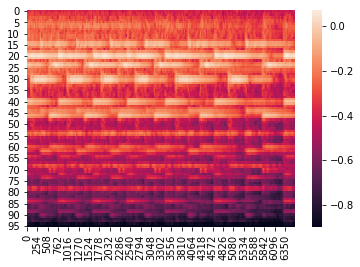

In [18]:
import seaborn as sns
sns.heatmap(train_dataset[100][0][0,:,:].numpy());

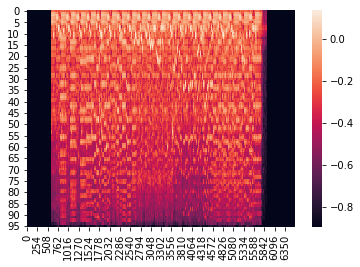

In [19]:
sns.heatmap(valid_dataset[100][0][0,:,:].numpy());

In [20]:
import torchvision.models

class mv2rnn(nn.Module):
    def __init__(self, embed_size = 512, num_layers = 2, output_dim = 56, batchsize = 100):
        super(mv2rnn,self).__init__()
       
        '''Encoder'''
        #self.bw2col = nn.Sequential(
        #    nn.BatchNorm2d(1),
        #   nn.Conv2d(1, 10, 1, padding=0), nn.ReLU(),
        #    nn.Conv2d(10, 3, 1, padding=0), nn.ReLU())
        # conv1d layers
        self.bw2col = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 10, 1, padding=0), nn.ReLU(),
            nn.Conv2d(10, 3, 1, padding=0), nn.ReLU())
        
        self.mv2 = torchvision.models.mobilenet_v2(pretrained=True)
        
        

        # add another fully connected layer
        self.embed = nn.Linear(1280, 512)
       
        # dropout layer
        self.dropout = nn.Dropout(p=0.5)
       
        # activation layers
        #self.prelu = nn.PReLU()
       
        '''Decoder'''
       
        self.hidden_dim1 = 128
        self.hidden_dim2 = 64
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.batch_size = batchsize
       
        # LSTM layer
        self.lstm = nn.LSTM(embed_size, self.hidden_dim1, self.num_layers, bidirectional = True)

        # output layer
        self.linear1 = nn.Linear(256, self.hidden_dim2)
       
        # output layer
        self.linear2 = nn.Linear(self.hidden_dim2, self.output_dim)
       
        # dropout layer
        self.dropout1 = nn.Dropout(p=0.4)
   
    def init_hidden(self):
        return (
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim1),
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim1),
        )
       
    def cnnencoder(self, images):
        x = self.bw2col(images)
        x = self.mv2.features(x)
        # get the embeddings from the densenet
        x = x.mean([2, 3])
        convnet_outputs = self.dropout(x)
       
        # pass through the fully connected
        embeddings = self.embed(convnet_outputs)
       
        return embeddings
   
    def rnndecoder(self, features):
        lstm_out, hidden = self.lstm(features.unsqueeze(1))
        logits1 = self.dropout1(self.linear1(lstm_out))
        logits = self.linear2(logits1.squeeze())
        genre_scores = (logits)
        return genre_scores
   
    def forward(self, inputs):
        embed = self.cnnencoder(inputs)
        output = self.rnndecoder(embed)
        return output
   
    def get_accuracy(self, logits, target):
        """ compute accuracy for training round """
        corrects = (
            torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum()
        accuracy = 100.0 * corrects / self.batch_size
        return accuracy.item()

In [21]:
cuda=True
device = torch.device('cuda:0' if cuda else 'cpu')
print('Device: ', device)

Device:  cuda:0


In [22]:
model = mv2rnn().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
criterion = nn.BCEWithLogitsLoss(reduction='none')

In [23]:
val_loader = DataLoader(valid_dataset, 4, shuffle=False)
train_loader_1 = DataLoader(train_dataset, 4, shuffle=True, drop_last=True)
train_loader_2 = DataLoader(train_dataset, 4, shuffle=True, drop_last=True)

In [24]:
epochs = 100

In [25]:
train_loss_hist = []
train_loss_hist_each_class = []

valid_loss_hist = []
valid_loss_hist_each_class = []

lowest_val_loss = np.inf
lowest_val_loss_each_class = np.array([float('inf') for _ in range(56)])
epochs_without_new_lowest = 0
k=0

for j in range(epochs):
    print('Epoch: ', j)
    
    this_epoch_train_loss = 0
    this_epoch_train_loss_each_class = np.zeros(56)
    #model.init_hidden()
    for i1, i2 in zip(train_loader_1, train_loader_2):
        
        k+=1
        #print('running set {} of epoch {}'.format(k,i))
        # mixup---------
        alpha = 1
        mixup_vals = np.random.beta(alpha, alpha, i1[0].shape[0])
        
        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1, 1, 1))
        inputs = (lam * i1[0]) + ((1 - lam) * i2[0])
        
        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1))
        labels = (lam * i1[1]) + ((1 - lam) * i2[1])
        # mixup ends ----------
        
        # https://stackoverflow.com/questions/55563376/pytorch-how-does-pin-memory-works-in-dataloader
        inputs = inputs.to(device, non_blocking=False)
        labels = labels.to(device, non_blocking=False)
        
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            model = model.train()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss = loss.mean(dim=0).mean(dim=0)
            total_loss.backward()
            optimizer.step()
            
            loss_val = total_loss.detach().cpu().numpy()
            loss_val_each_class = loss.mean(dim=0).detach().cpu().numpy()
            
            this_epoch_train_loss += loss_val
            this_epoch_train_loss_each_class += loss_val_each_class
    
    this_epoch_valid_loss = 0
    this_epoch_valid_loss_each_class = np.zeros(56)
    for inputs, labels in val_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            loss_val = loss.mean(dim=0).mean(dim=0).detach().cpu().numpy()
            loss_val_each_class = loss.mean(dim=0).detach().cpu().numpy()
            
            this_epoch_valid_loss += loss_val
            this_epoch_valid_loss_each_class += loss_val_each_class
    
    this_epoch_train_loss /= len(train_loader_1)
    this_epoch_train_loss_each_class /= len(train_loader_1)
    
    this_epoch_valid_loss /= len(val_loader)
    this_epoch_valid_loss_each_class /= len(val_loader)
    
    train_loss_hist.append(this_epoch_train_loss)
    train_loss_hist_each_class.append(this_epoch_train_loss_each_class)
    valid_loss_hist.append(this_epoch_valid_loss)
    valid_loss_hist_each_class.append(this_epoch_valid_loss_each_class)
    
    if this_epoch_valid_loss < lowest_val_loss:
        lowest_val_loss = this_epoch_valid_loss
        torch.save(model.state_dict(), './mv2modmodel')
        epochs_without_new_lowest = 0
    else:
        epochs_without_new_lowest += 1
    
    for i in range(56):
        if this_epoch_valid_loss_each_class[i] < lowest_val_loss_each_class[i]:
            lowest_val_loss_each_class[i] = this_epoch_valid_loss_each_class[i]
            torch.save(model.state_dict(), './mv2modmodel_c{}'.format(i))
    
    if epochs_without_new_lowest >= 25:
        send('Training Complete')
        break
    print(this_epoch_train_loss, this_epoch_valid_loss)
    send('epoch number {} done, train loss = {}, valid loss = {}'.format(j,this_epoch_train_loss, this_epoch_valid_loss))
    
    scheduler.step(this_epoch_valid_loss)

Epoch:  0
0.14438152450740122 0.1296289084022855
Epoch:  1
0.13921621135369716 0.12983990077528668
Epoch:  2
0.13886466102579487 0.13034478079852746
Epoch:  3
0.13848655915638985 0.13014965557682276
Epoch:  4
0.13827724509453457 0.12939619305852085
Epoch:  5
0.13842083016132609 0.12907522962233747
Epoch:  6
0.13792114320784435 0.1291775211268795
Epoch:  7
0.13776278862176192 0.12964759696545286
Epoch:  8
0.13726081310875884 0.12951112326262
Epoch:  9
0.13778404397781374 0.12910817320665224
Epoch:  10
0.1376666928067426 0.12936142448935223
Epoch:  11
0.13727753465919548 0.1297228527730321
Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  12
0.13735632291629127 0.12883002600083215
Epoch:  13
0.13745073840818972 0.12891803157724416
Epoch:  14
0.1366888558799884 0.12898457656711435
Epoch:  15
0.13692356116401655 0.12898254208070872
Epoch:  16
0.1373471451401231 0.12897657085950442
Epoch:  17
0.13752109151757477 0.1289129995600909
Epoch:  18
0.13716248452220042 0.1289015

In [ ]:
labels.type(torch.LongTensor).shape

In [26]:
model.load_state_dict(torch.load('./mv2modmodel'))

<All keys matched successfully>

In [27]:
val_loader = DataLoader(valid_dataset, 16, shuffle=False)

In [28]:
this_epoch_valid_loss = 0
all_outputs = []
all_inputs = []
for inputs, labels in val_loader:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        model = model.eval()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss_val = loss.mean(dim=0).mean(dim=0).detach().cpu().numpy()
        this_epoch_valid_loss += loss_val
        
        all_outputs.append(outputs.detach().cpu().numpy())
        all_inputs.append(labels.detach().cpu().numpy())
        

this_epoch_valid_loss /= len(val_loader)

In [29]:
this_epoch_valid_loss

0.12878644920322074

In [30]:
all_outputs = np.concatenate(all_outputs, axis=0)
all_inputs  = np.concatenate(all_inputs,  axis=0)

In [31]:
all_outputs = 1 / (1 + np.exp(-all_outputs))

In [32]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [33]:
roc_auc_score(all_inputs, all_outputs, average='macro')

0.4983271251499693

In [34]:
average_precision_score(all_inputs, all_outputs, average='macro')

0.03133336971841338

In [35]:
pd.DataFrame.from_records([
    (i, roc_auc_score(all_inputs[:, i], all_outputs[:, i]).round(2))
    for i in range(56)
])

,0,1
0,0,0.46
1,1,0.54
2,2,0.51
3,3,0.51
4,4,0.49
5,5,0.50
6,6,0.55
7,7,0.50
8,8,0.52
9,9,0.52


In [36]:
final_inputs = []
final_outputs = []
for i in range(56):
    model.load_state_dict(torch.load('./mv2modmodel_c{}'.format(i)))
    val_loader = DataLoader(valid_dataset, 16, shuffle=False)
    this_epoch_valid_loss = 0
    all_outputs = []
    all_inputs = []
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val = loss.mean(dim=0).mean(dim=0).detach().cpu().numpy()
            this_epoch_valid_loss += loss_val
            all_outputs.append(outputs.detach().cpu().numpy())
            all_inputs.append(labels.detach().cpu().numpy())
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_inputs  = np.concatenate(all_inputs,  axis=0)
    final_inputs.append(all_inputs[:, [i]])
    final_outputs.append(all_outputs[:, [i]])

In [37]:
all_inputs = np.concatenate(final_inputs, axis=-1)
all_outputs = np.concatenate(final_outputs, axis=-1)

In [38]:
all_outputs = 1 / (1 + np.exp(-all_outputs))

In [39]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [40]:
roc_auc_score(all_inputs, all_outputs, average='macro')

0.49767110749476934

In [41]:
average_precision_score(all_inputs, all_outputs, average='macro')

0.031005169138897677

In [42]:
pd.DataFrame.from_records([
    (i, roc_auc_score(all_inputs[:, i], all_outputs[:, i]).round(2))
    for i in range(56)
])

,0,1
0,0,0.51
1,1,0.46
2,2,0.51
3,3,0.49
4,4,0.48
5,5,0.49
6,6,0.54
7,7,0.49
8,8,0.56
9,9,0.51


In [43]:
from sklearn.metrics import precision_recall_curve

In [44]:
# Optimized macro F-score
thresholds = {}
for i in range(56):
    precision, recall, threshold = precision_recall_curve(all_inputs[:, i], all_outputs[:, i])
    f_score = np.nan_to_num((2 * precision * recall) / (precision + recall))
    thresholds[i] = threshold[np.argmax(f_score)]
print(f_score)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


[0.07080998 0.07033639 0.07042613 0.07046209 0.07053412 0.07060629
 0.07067862 0.07071483 0.07029246 0.0703466  0.07047325 0.07060036
 0.07037516 0.07046632 0.07068607 0.07081489 0.071165   0.07146638
 0.0712743  0.07129355 0.07077256 0.07079168 0.07081081 0.07090663
 0.07092583 0.07100271 0.07106048 0.07109905 0.07125374 0.07131192
 0.07017544 0.07021393 0.07026279 0.07047725 0.06993796 0.07151096
 0.07155222 0.07157287 0.07159353 0.07165559 0.0716763  0.07171776
 0.07175926 0.07178003 0.07140784 0.07153242 0.07147042 0.07161726
 0.07268394 0.07340554 0.07249071 0.07251317 0.07253565 0.07255814
 0.07258065 0.07260316 0.07271597 0.07276119 0.07285181 0.07294264
 0.07314786 0.07321652 0.07284144 0.07307087 0.0714058  0.0715198
 0.07277453 0.07325049 0.0735786  0.07360321 0.07362784 0.07365249
 0.07370184 0.07372654 0.07375126 0.07377599 0.07387508 0.07394958
 0.07399933 0.07427414 0.07369844 0.07281388 0.07235495 0.07301808
 0.07313643 0.0728863  0.07291287 0.07301935 0.07304602 0.07328

In [45]:
final_outputs = []
for i in range(56):
    model.load_state_dict(torch.load('./mv2modmodel_c{}'.format(i)))
    test_loader = DataLoader(test_dataset, 32, shuffle=False)
    all_outputs = []
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            all_outputs.append(outputs.detach().cpu().numpy())
    all_outputs = np.concatenate(all_outputs, axis=0)
    final_outputs.append(all_outputs[:, [i]])

In [46]:
all_outputs = np.concatenate(final_outputs, axis=-1)

In [47]:
all_outputs = 1 / (1 + np.exp(-all_outputs))

In [48]:
all_outputs.shape, all_outputs.astype('float64').dtype

((4231, 56), dtype('float64'))

In [49]:
np.save('modmodelpredictions.npy', all_outputs.astype('float64'))

In [50]:
decisions = []
for i in range(56):
    decisions.append(
        all_outputs[:, [i]] > thresholds[i]
    )
decisions = np.concatenate(decisions, axis=-1)

In [51]:
decisions.shape, decisions.dtype

((4231, 56), dtype('bool'))

In [52]:
np.save('modmodeldecisions.npy', decisions)

AttributeError: module 'matplotlib.pyplot' has no attribute 'legends'

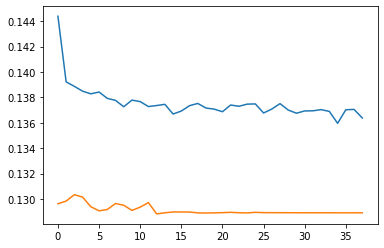

In [53]:
plt.plot(train_loss_hist, label = 'train loss')
plt.plot(valid_loss_hist, label = 'valid loss')
plt.legends()
plt.show()

In [54]:
import dill
dill.dump_session('mv2modmodel_env.db')

In [55]:
send('done bro done')